### Importing the Dataset

In [2]:
import os,json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from glob import glob
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend as K
from sklearn.model_selection import KFold
from PIL import Image

In [3]:
print(tf.keras.__version__)
print(tf.__version__)

2.7.0
2.7.0


### Processing the Data

In [4]:
path = "C:/Users/shrey/OneDrive - Nanyang Technological University/Desktop/Dataset/trainingSet/trainingSet/FinalSet/"
path2 = "C:/Users/shrey/OneDrive - Nanyang Technological University/Desktop/Dataset/testSet/final_test/"

In [5]:
img_width, img_height = 28,28

data = []
for root,dirs,files in os.walk(path,topdown=True):
    for name in files:
        if '.jpeg' not in name:
            continue
        filename = os.path.abspath(os.path.join(root,name))
        class_name = name[0]
        data.append((filename,class_name))

df = pd.DataFrame(data,columns=['filename','class_name'])
df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

df = df.sample(frac=1).reset_index(drop=True)
print(df.head())
print(len(df))
df.dtypes

                                            filename class_name  class
0  C:\Users\shrey\OneDrive - Nanyang Technologica...          3      3
1  C:\Users\shrey\OneDrive - Nanyang Technologica...          5      5
2  C:\Users\shrey\OneDrive - Nanyang Technologica...          6      6
3  C:\Users\shrey\OneDrive - Nanyang Technologica...          6      6
4  C:\Users\shrey\OneDrive - Nanyang Technologica...          5      5
60000


filename        object
class_name    category
class             int8
dtype: object

In [6]:
df.shape

(60000, 3)

In [7]:
#for training set
data2 = []
for root,dirs,files in os.walk(path2,topdown=True):
    for name in files:
        if'.jpeg' not in name:
            continue
        filename = os.path.abspath(os.path.join(root,name))
        class_name = name[10]
        data2.append((filename, class_name))
        
df2 = pd.DataFrame(data2, columns=['filename','class_name'])
df2['class_name'] = df2['class_name'].astype('category')
df2['class'] = df2['class_name'].cat.codes

#shuffle
df2 = df2.sample(frac=1).reset_index(drop=True)

print(df2.head())
print(len(df2))
df2.dtypes

                                            filename class_name  class
0  C:\Users\shrey\OneDrive - Nanyang Technologica...          3      3
1  C:\Users\shrey\OneDrive - Nanyang Technologica...          3      3
2  C:\Users\shrey\OneDrive - Nanyang Technologica...          5      5
3  C:\Users\shrey\OneDrive - Nanyang Technologica...          8      8
4  C:\Users\shrey\OneDrive - Nanyang Technologica...          7      7
10000


filename        object
class_name    category
class             int8
dtype: object

In [8]:
df2.shape

(10000, 3)

### Make the pipeline for laoding and resizing the images

#### Image Resizing and Decoding

In [51]:
X_train = []
for i in df['filename']:
    img = Image.open(i)
    X_train.append(np.asarray(img))

X_train = np.array(X_train)

In [52]:
y_train = []
for i in df['class']:
    y_train.append(i)

y_train = np.array(y_train)
print("Shape of X train is: ",X_train.shape)
print("Shape of y train is ",y_train.shape)

Shape of X train is:  (60000, 28, 28)
Shape of y train is  (60000,)


In [53]:
X_test = []
for i in df2['filename']:
    img = Image.open(i)
    X_test.append(np.asarray(img))

X_test = np.array(X_test)

In [55]:
y_test = []
for i in df2['class']:
    y_test.append(i)

y_test = np.array(y_test)
print("Shape of X train is: ",X_test.shape)
print("Shape of y train is ",y_test.shape)

Shape of X train is:  (10000, 28, 28)
Shape of y train is  (10000,)


In [56]:
num_classes = 10

# reshaping dataset to have a single channel
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

#one hot encode target values
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

#Preparing pixel for data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255.0
X_test = X_test/255.0

print("Shape of train set: ",X_train.shape)
print("Shape of test set: ",X_test.shape)

Shape of train set:  (60000, 28, 28, 1)
Shape of test set:  (10000, 28, 28, 1)


### Creating the model

In [57]:
epochs = 10

def create_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  
  ### Compiling CNN
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),metrics=['accuracy'])
  return model

### Train and evaluate the model

In [58]:
def evaluation(dataX,dataY):
  scores = []
  history = []
  prev = 0
  kfold = KFold(5,shuffle=True, random_state=1)
  #enumarte the splits
  for ix_train, ix_test in kfold.split(dataX):
    #define the model
    model = create_model()
    trainX,trainY,testX,testY = dataX[ix_train],dataY[ix_train],dataX[ix_test],dataY[ix_test]
    #fit the model
    hist = model.fit(trainX,trainY, epochs = 10, batch_size= 32, validation_data=(testX,testY),verbose=0)
    _,acc = model.evaluate(testX,testY,verbose=0)
    if(acc > prev):
      model.save('mnist.h5')
      prev = acc
    print('> %.3f' % (acc*100.0))
    #store results
    scores.append(acc)
    history.append(hist)
  return scores,history

### Plotting learning curves

In [59]:
def plotting_learn(histories):
  for i in range(len(histories)):
    plt.subplot(2,1,1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'],color='blue', label='train')
    plt.plot(histories[i].history['val_loss'],color='orange', label='test')

    # plotting accuracy
    plt.subplot(2,1,2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'],color='blue',label='train')
    plt.plot(histories[i].history['val_accuracy'],color='orange',label='test')
  plt.show()

> 98.892
> 98.825
> 99.000
> 98.792
> 98.517


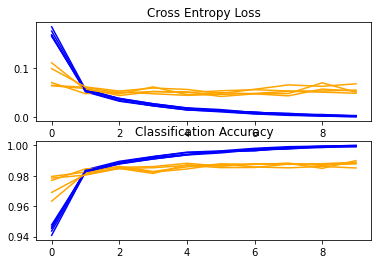

In [60]:
def run_test():
  scores,history = evaluation(X_train,y_train)
  plotting_learn(history)

run_test()

### Saving Final Model

In [61]:
def run_test_final():
  model = create_model()
  model.fit(X_train,y_train,epochs=10,batch_size=32,verbose=0)
  model.save('canny_model.h5')

In [62]:
run_test_final()

In [63]:
model = tf.keras.models.load_model("C:/Users/shrey/OneDrive - Nanyang Technological University/Desktop/MLAI projects/DigitRecog/canny_model.h5")
_, acc = model.evaluate(X_test,y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 98.980


### Predicting a handwritten image

In [91]:
path = 'C:/Users/shrey/OneDrive - Nanyang Technological University/Desktop/MLAI projects/DigitRecog/Digit/9.png'
img=cv2.imread(path)
img=cv2.resize(img, (28, 28))
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray,(3,3), 0)
edges = cv2.Canny(image=img_blur, threshold1=100,threshold2=200)
cv2.imshow("Edged",edges)
img_first_array = img_to_array(edges)
img_array = img_first_array.reshape(1,28,28,1)
img = img_array.astype('float32')
img = img/255
predict = model.predict(img)
digit = np.argmax(predict)
print(digit)
cv2.waitKey(0)
cv2.destroyAllWindows()

9
